# Read MNIST data

In [1]:
import numpy as np
import scipy.io as sio

In [2]:
mnist_all = sio.loadmat("../pmtk3/bigData/mnistAll/mnistAll.mat", squeeze_me=True)

In [3]:
train_X = mnist_all["mnist"]["train_images"].item()
train_y = mnist_all["mnist"]["train_labels"].item()

test_X = mnist_all["mnist"]["test_images"].item()
test_y = mnist_all["mnist"]["test_labels"].item()

In [4]:
train_X.shape

(28, 28, 60000)

In [5]:
test_X.shape

(28, 28, 10000)

## Plot sample images

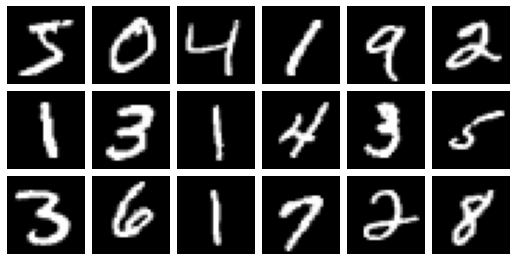

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(9, 6))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 6), axes_pad=0.1)

for i, ax in enumerate(grid):
    ax.imshow(train_X[:, :, i], cmap="gray")
    ax.axis("off")

plt.show()

# Exercise 1.1

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
train_X_flat = train_X.reshape(28 * 28, 60000).transpose()
test_X_flat = test_X.reshape(28 * 28, 10000).transpose()

In [10]:
%%time

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_X_flat, train_y);

CPU times: user 13.9 s, sys: 139 ms, total: 14.1 s
Wall time: 14.1 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [11]:
%%time

y_hat = knn.predict(test_X_flat)

CPU times: user 9min 48s, sys: 763 ms, total: 9min 49s
Wall time: 9min 50s


## Accuracy

In [14]:
print(f"Error rate is {(10000 - (y_hat == test_y).sum())/100:.2f}%")

Error rate is 3.09%


# Exercise 1.2

In [15]:
from pyflann import FLANN

In [16]:
%%time

flann = FLANN()
result, dists = flann.nn(train_X_flat, test_X_flat, 1)
y_hat_flann = train_y[result]

print(f"Error rate is {(10000 - (y_hat_flann == test_y).sum())/100:.2f}%")

Error rate is 4.85%
CPU times: user 561 ms, sys: 11.5 ms, total: 572 ms
Wall time: 574 ms


In [17]:
%%time

flann = FLANN()
result, dists = flann.nn(train_X_flat, test_X_flat, 1, algorithm="kmeans")
y_hat_flann = train_y[result]

print(f"Error rate is {(10000 - (y_hat_flann == test_y).sum())/100:.2f}%")

Error rate is 3.84%
CPU times: user 17.8 s, sys: 65.3 ms, total: 17.9 s
Wall time: 17.9 s


# Exercise 1.3

In [18]:
def knn(train_X, train_y, test_X, test_y, k=1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_X, train_y)

    def accuracy(X, y):
        y_hat = knn.predict(X)
        return (y.size - (y_hat == y).sum()) / y.size

    return (accuracy(train_X, train_y), accuracy(test_X, test_y))

In [19]:
X = test_X_flat[0:1000]
y = test_y[0:1000]

In [20]:
def cv(X, y, folds, k):
    train_acc = []
    test_acc = []
    batch_size = int(y.size / folds)
    for i in range(folds):
        print("Iteration", i + 1, sep=": ", end="\r")
        test_ix = np.index_exp[batch_size * i : batch_size * (i + 1)]
        train_ix = np.ones(y.size, dtype=bool)
        train_ix[test_ix] = False

        train, test = knn(X[train_ix], y[train_ix], X[test_ix], y[test_ix], k)
        train_acc.append(train)
        test_acc.append(test)

    return (sum(train_acc) / folds, sum(test_acc) / folds)

In [24]:
ks = [1, 2, 3, 5, 10, 20, 50, 100, 120]
accuracy = []
for k in ks:
    accuracy.append(cv(X, y, 5, k))

In [25]:
list(zip(ks, accuracy))

[(1, (0.0, 0.138)),
 (2, (0.081, 0.17500000000000002)),
 (3, (0.08700000000000001, 0.157)),
 (5, (0.10475000000000001, 0.161)),
 (10, (0.142, 0.178)),
 (20, (0.17225000000000001, 0.20099999999999998)),
 (50, (0.24674999999999997, 0.257)),
 (100, (0.329, 0.335)),
 (120, (0.35750000000000004, 0.378))]

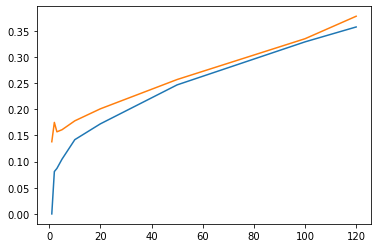

In [26]:
plt.plot(ks, [x[0] for x in accuracy])
plt.plot(ks, [x[1] for x in accuracy])

plt.show()

Not sure why the best accuracy is with K=1 on test set. Otherwise inline with the book. 